# Article title classification using PhoBERT
- Input:
    - Title: Tiêu đề 1 bài báo của bất cứ trang web báo chí nào chính thống.
- Output:
    - Topic: Thể loại bài báo đó.

Link Website để thu thập dữ liệu: https://vtv.vn/


## 1. Import library

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import csv

from wordcloud import WordCloud
import plotly.express as px
from collections import Counter
from nltk.corpus import stopwords
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, make_scorer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate

c:\Users\huuhu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stop_words = set(stopwords.words('vietnamese')) 

In [3]:
# Load pre-trained PhoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base")
encode_lable = LabelEncoder()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Craw Data

In [4]:
def save(name, a):
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    dataset = pd.DataFrame(data=df)
    dataset.to_excel(f'./Raw Data/{name}.xlsx', encoding='utf-8-sig')

In [5]:
def get_data(name, dict_url):

    driver = webdriver.Edge("./msedgedriver.exe")

    Contents = []
    Topic = []
    dictionary = {'Content': Contents, 'Topic': Topic}

    for _topic, quantity in dict_url.items():
        driver.get(f'https://vtv.vn/{_topic}.htm')
        content = []
        count = 0
        status = True
        while status:
            items = driver.find_elements(By.XPATH, '/html/body/form/div[2]/div[3]/div[3]/div/div[1]/div[1]/div[3]/div[1]/ul/li')

            for item in items:
                if count >= quantity:
                    status = False
                    break
                # Tìm tiêu đề tin tức
                content.append(item.find_element(By.XPATH,  './/h4/a').text)
                topic = [_topic for _ in range(len(content))]
                count += 1

                
            # Tìm nút "Xem thêm"
            load_more_button = driver.find_element(By.XPATH, '/html/body/form/div[2]/div[3]/div[3]/div/div[1]/div[1]/div[3]/div[2]/a')

            if not load_more_button.is_displayed():
                break
            load_more_button.click()

            time.sleep(5)
        Topic.extend(topic)
        Contents.extend(content)
    save(name, dictionary)

In [6]:
dict_url_big = {    'chinh-tri':        1856,
                    'xa-hoi':           1005,
                    'kinh-te':          2326,
                    'truyen-hinh':      2164,
                    'cong-nghe':        548,
                    'doi-song':         1456,
                    'van-hoa-giai-tri': 1564
                }

dict_url_small = {  'chinh-tri':        213,
                    'xa-hoi':           113,
                    'kinh-te':          566,
                    'truyen-hinh':      36,
                    'cong-nghe':        156,
                    'doi-song':         102,
                    'van-hoa-giai-tri': 189
                }
dict_url_test = {   'chinh-tri':        2,
                    'xa-hoi':           2,
                    'kinh-te':          2,
                    'truyen-hinh':      2,
                    'cong-nghe':        2,
                    'doi-song':         2,
                    'van-hoa-giai-tri': 2
                }
# get_data("big_data", dict_url_big)
# get_data("small_data", dict_url_small)
# get_data("test_data", dict_url_test)

## Load Data

In [7]:
def read_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Content', 'Topic']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

In [8]:
df_small = read_data('./Raw Data/small_data.xlsx')
df_big = read_data('./Raw Data/big_data.xlsx')

In [9]:
df_small.head()

,Content,Topic
0,Quán triệt các quy định của Ban Bí thư về báo ...,chinh-tri
1,Phó Thủ tướng Trần Hồng Hà: Không để thiếu vac...,chinh-tri
2,ASEAN cần thích ứng năng động và tăng cường sứ...,chinh-tri
3,Tiếp tục hoàn thiện cơ chế xác định giá đất,chinh-tri
4,Bộ Công an trao tặng Giải thưởng Trần Quốc Hoà...,chinh-tri


In [10]:
df_big.head()

,Content,Topic
0,Thủ tướng Chính phủ Phạm Minh Chính tiếp Thống...,chinh-tri
1,Chủ tịch Hội đồng Châu Âu đánh giá cao nỗ lực ...,chinh-tri
2,Thủ tướng Phạm Minh Chính gặp Tổng thống Hoa Kỳ,chinh-tri
3,Tổng Thư ký OECD ấn tượng trước vai trò quốc t...,chinh-tri
4,Hội nghị thượng đỉnh G7 mở rộng: Nỗ lực chung ...,chinh-tri


## Exploratory data analysis

In [11]:
def plot_topic(df):
    plt.figure(figsize=(20, 10))
    sns.countplot(x='Topic', data=df)
    plt.title("Number of sample")
    plt.show()

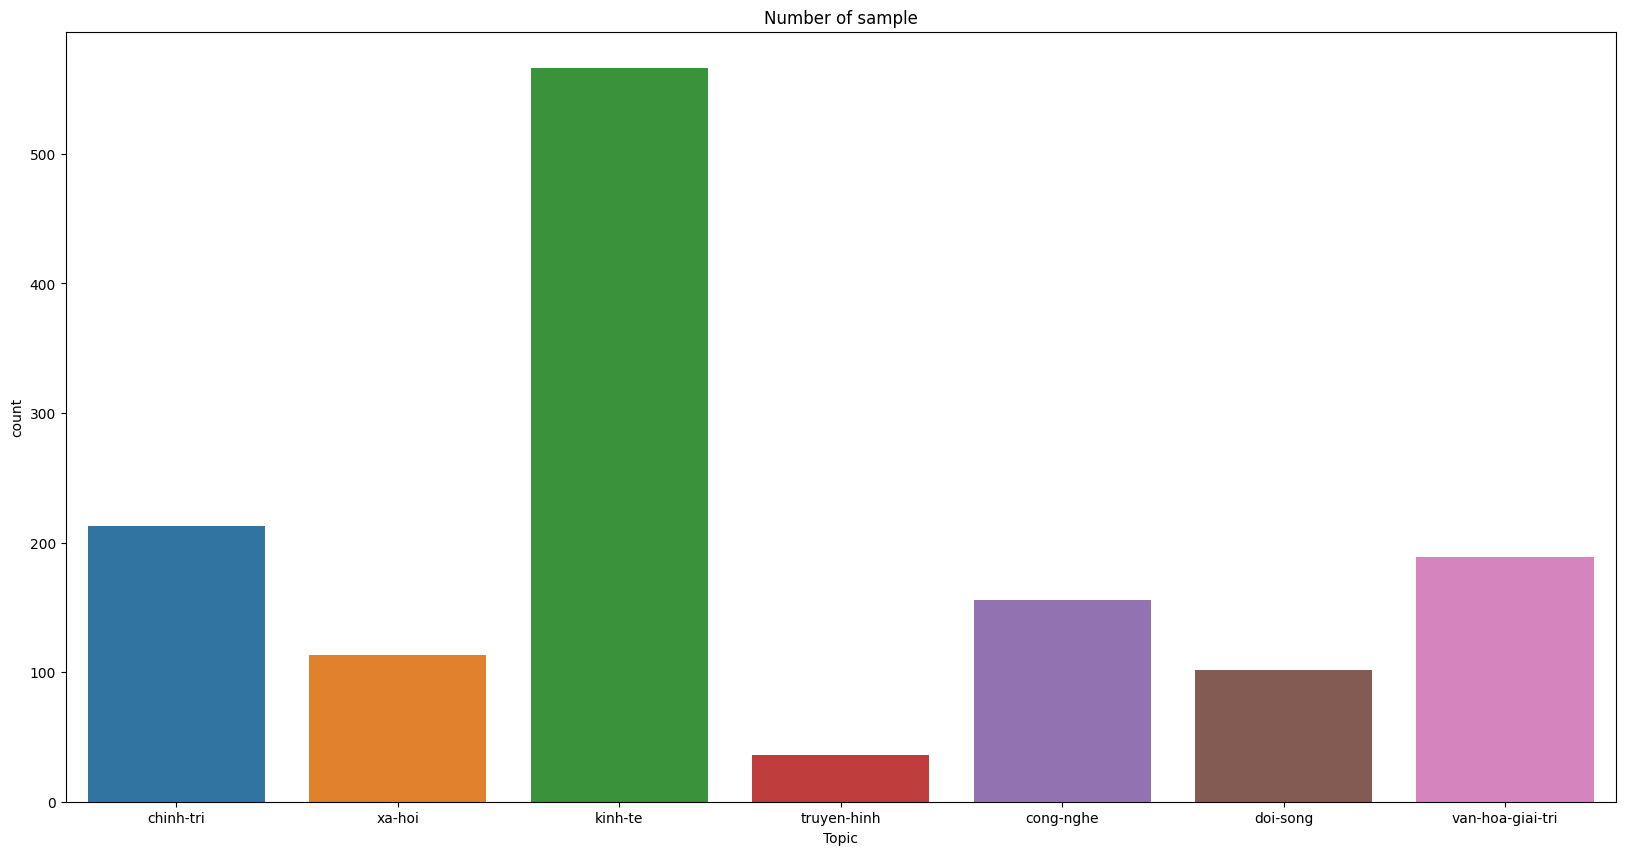

In [12]:
plot_topic(df_small)

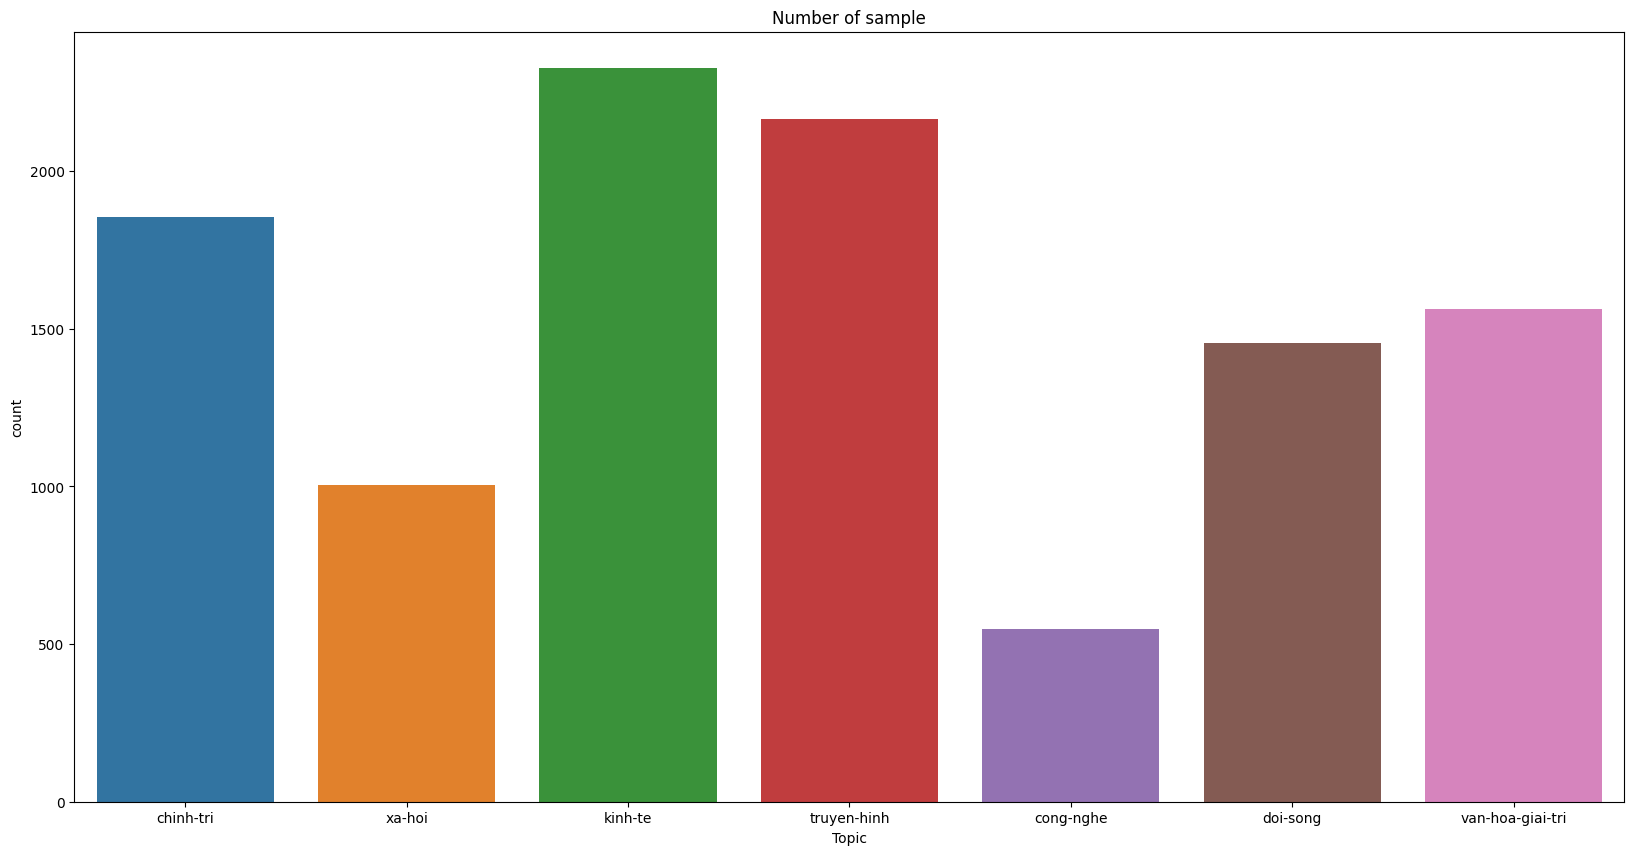

In [13]:
plot_topic(df_big)

In [14]:
df_big['Topic'].value_counts()

kinh-te             2326
truyen-hinh         2164
chinh-tri           1856
van-hoa-giai-tri    1564
doi-song            1456
xa-hoi              1005
cong-nghe            548
Name: Topic, dtype: int64

In [15]:
df_small['Topic'].value_counts()

kinh-te             566
chinh-tri           213
van-hoa-giai-tri    189
cong-nghe           156
xa-hoi              113
doi-song            102
truyen-hinh          36
Name: Topic, dtype: int64

In [16]:
def group_topic(topic):
    if topic in ['chinh-tri']:
        return 'chinh-tri'
    elif (topic in ['kinh-te']):
        return 'kinh-te'
    elif (topic in ['cong-nghe']):
        return 'Công-nghệ'
    elif (topic in ['xa-hoi']):
        return 'xa-hoi'
    else: 
        return 'Khác'

In [17]:
df_small['Topic'] = df_small['Topic'].apply(lambda topic: group_topic(topic))
df_big['Topic'] = df_big['Topic'].apply(lambda topic: group_topic(topic))

In [18]:
df_small['Topic'].value_counts()

kinh-te      566
Khác         327
chinh-tri    213
Công-nghệ    156
xa-hoi       113
Name: Topic, dtype: int64

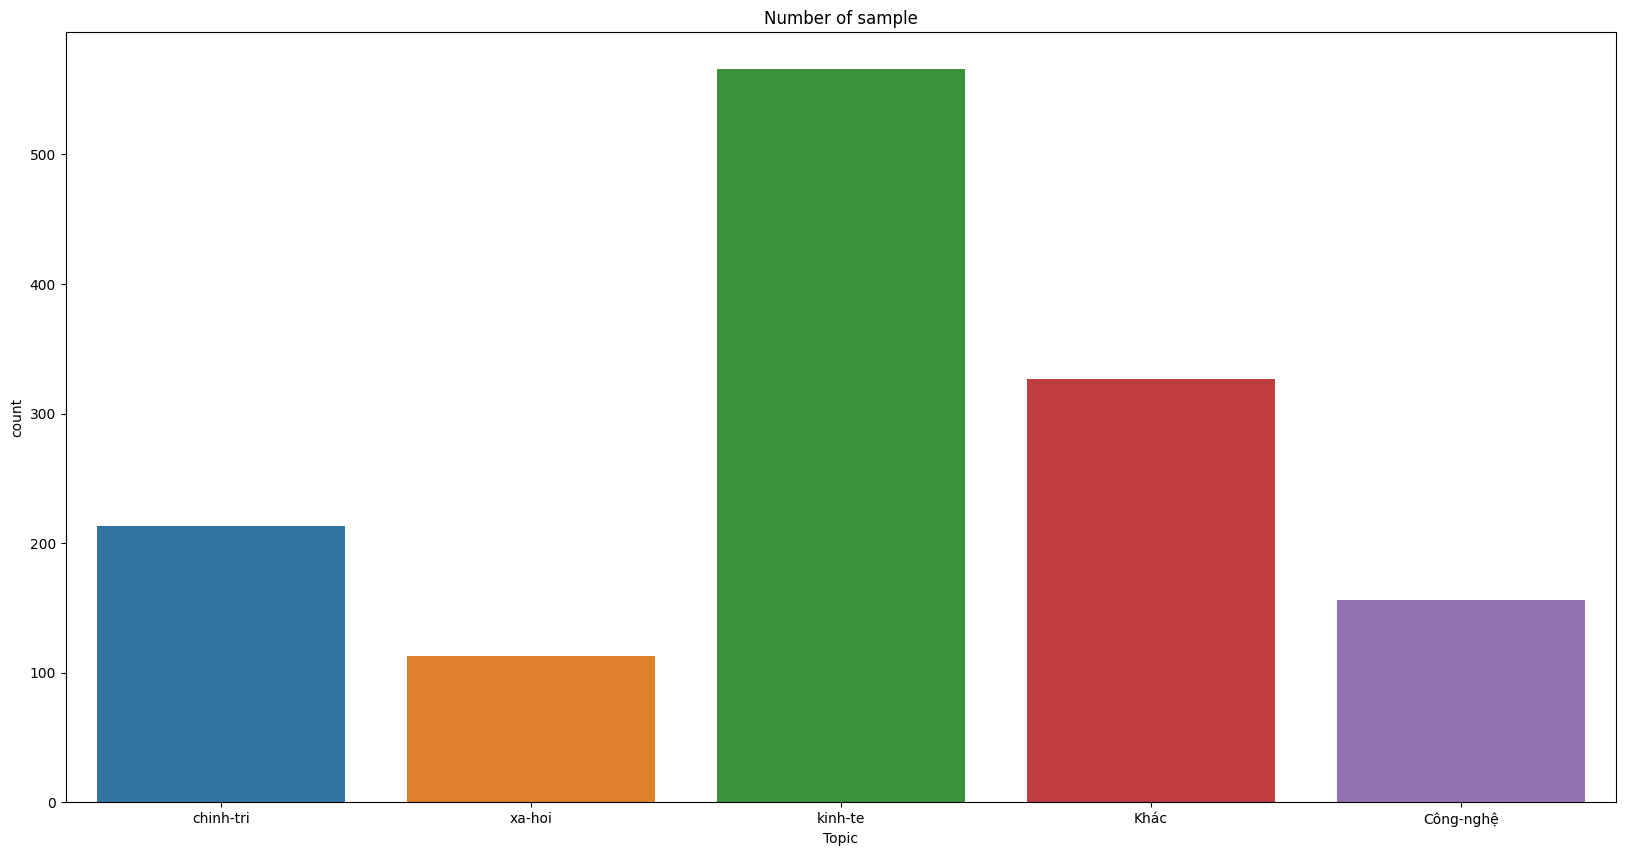

In [19]:
plot_topic(df_small)

In [20]:
df_big['Topic'].value_counts()

Khác         5184
kinh-te      2326
chinh-tri    1856
xa-hoi       1005
Công-nghệ     548
Name: Topic, dtype: int64

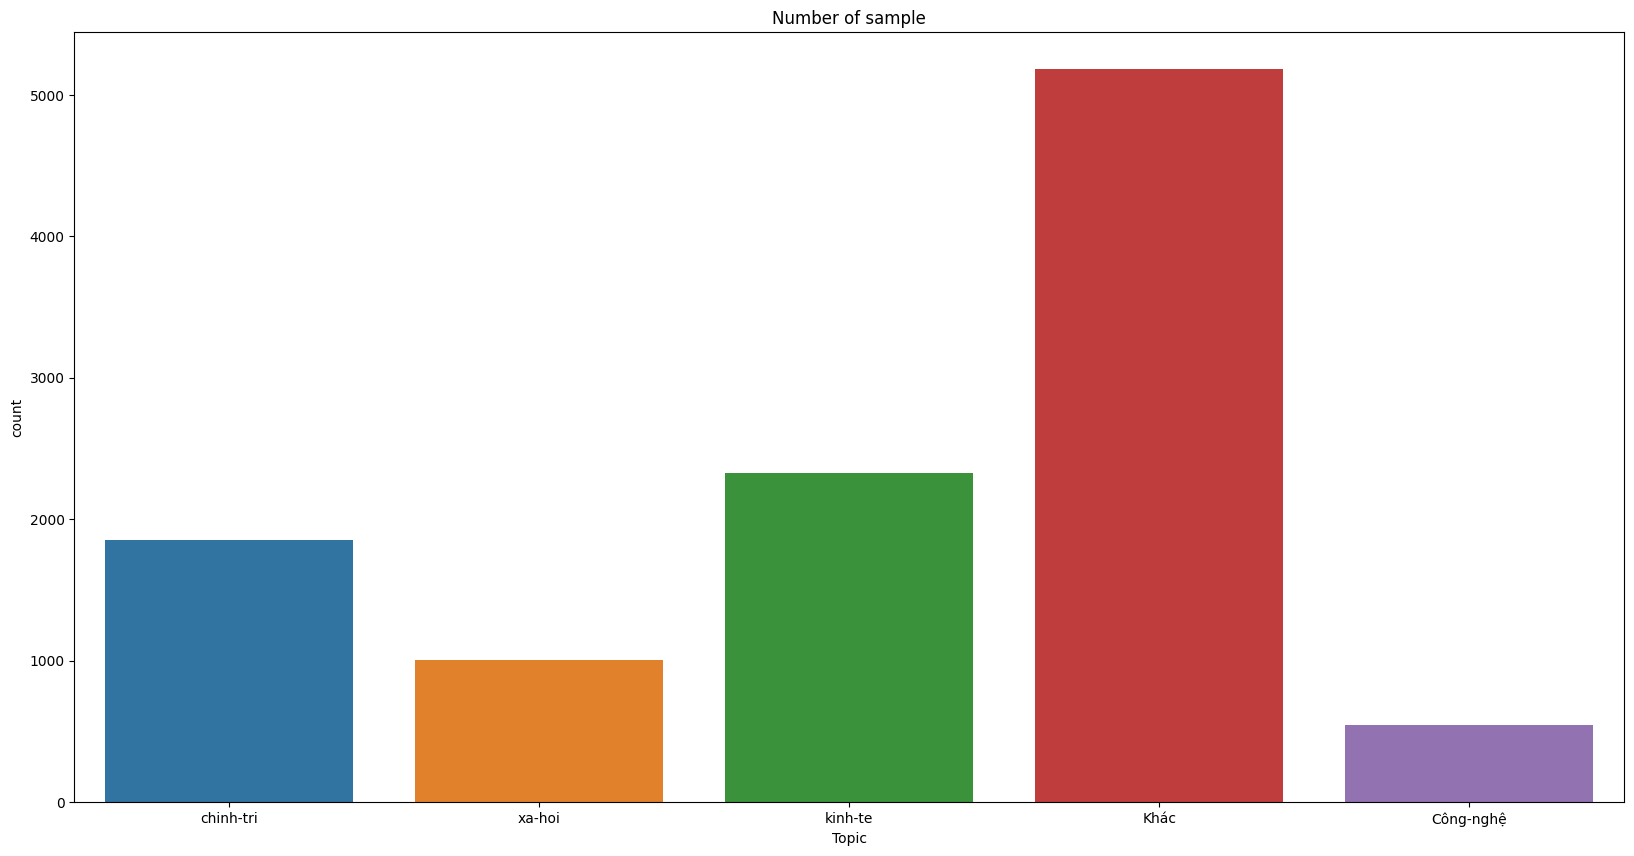

In [21]:
plot_topic(df_big)

In [22]:
def plot_count_token():
    all_data = df_big['Content'].tolist() + df_small['Content'].tolist()
    token_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
    token_lens = [len(text) for text in token_text]

    sns.set(rc={'figure.figsize':(20, 10)})
    sns.displot(token_lens, height=5, aspect=3)
    plt.xlim([0,max(token_lens)])
    plt.xlabel('Token Count')
    plt.show()

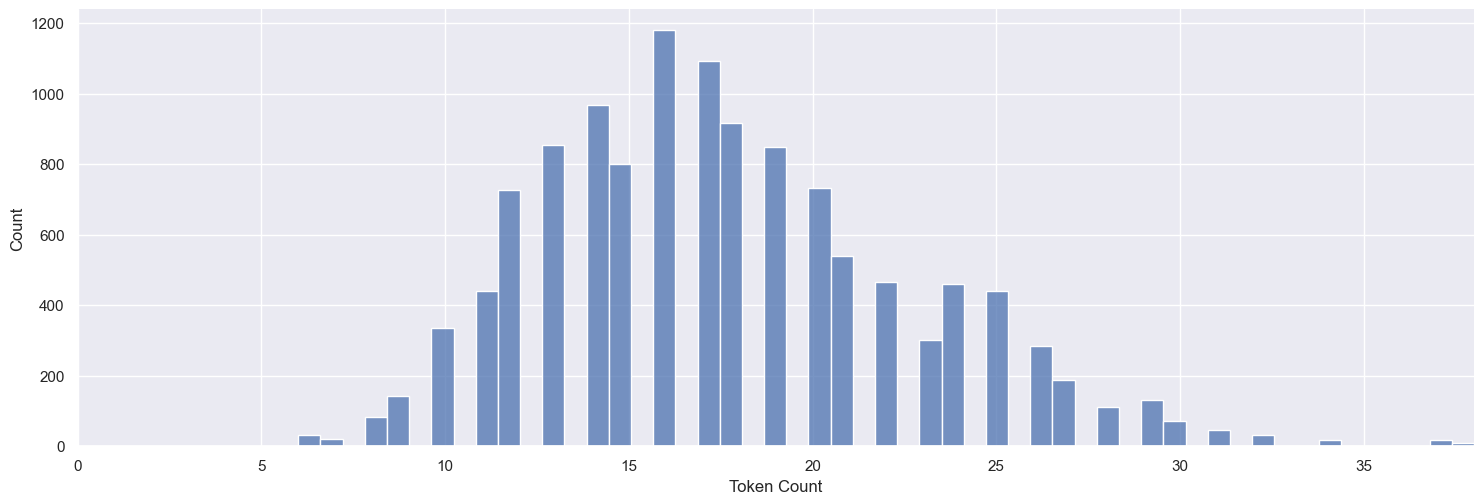

In [23]:
plot_count_token()

In [24]:
def top_word():
    top = Counter([item for sublist in df_big['Content'].apply(lambda x:str(x).split()) for item in sublist])
    print(len(top))
    temp = pd.DataFrame(top.most_common(50))
    temp.columns = ['Common_words','count']
    return temp

In [25]:
top_word = top_word()
top_word.style.background_gradient(cmap='Blues')

3290


,Common_words,count
0,của,1766
1,Nam,1425
2,Việt,1360
3,-,1357
4,và,971
5,các,915
6,trong,830
7,cho,743
8,tại,715
9,có,686


In [26]:
fig = px.bar(top_word, x="count", y="Common_words", title='Commmon Words in Contents', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

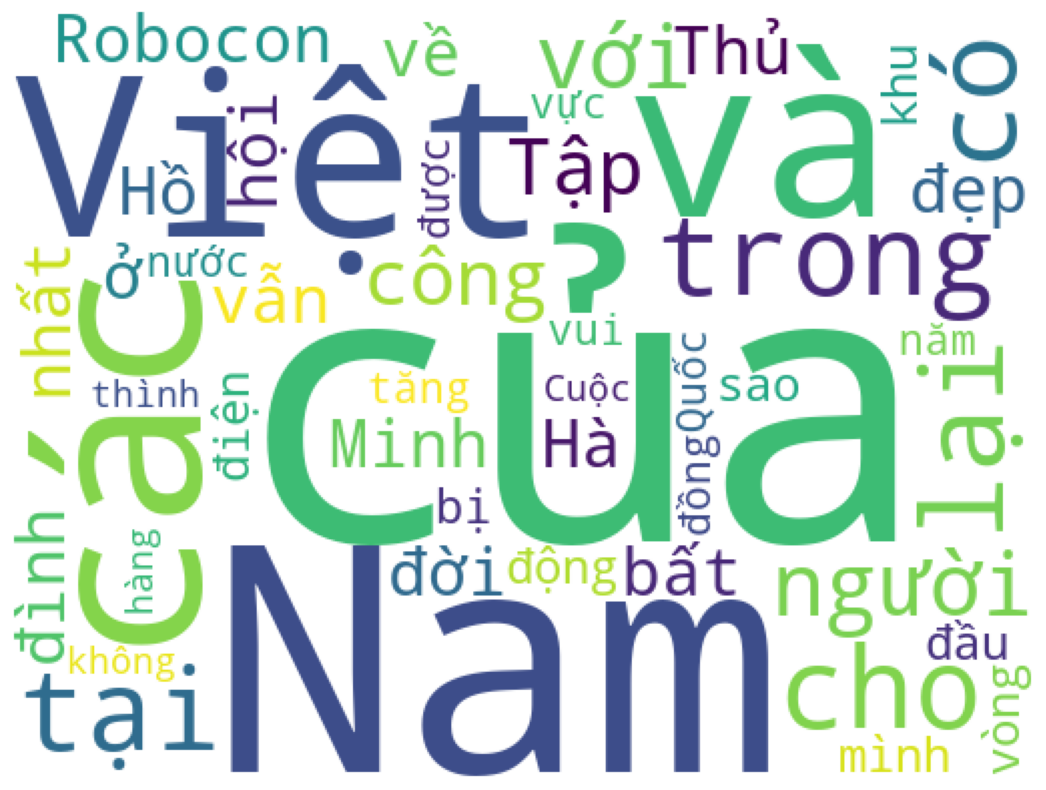

In [27]:
plt.subplots(figsize=(20, 10))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(top_word['Common_words']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.savefig('Plotly-World_Cloud.png')
plt.show()

## Cleaning and Processing data

In [28]:
def remove_stop_words(content):
    text = ' '.join(word for word in content.split() if word not in stop_words)
    return text

In [29]:
def removing_numbers(content):
    content = ''.join([i for i in content if not i.isdigit()])
    return content

In [30]:
def lower_case(content):
    content = content.split()
    content = [y.lower() for y in content]
    return " " .join(content)

In [31]:
def Removing_punctuations(content):
    ## Remove punctuations
    content = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', content)
    content = content.replace('؛',"", )
    
    ## remove extra whitespace
    content = re.sub('\s+', ' ', content)
    content =  " ".join(content.split())
    return content.strip()

In [32]:
def normalized_sentence(content):
    content = lower_case(content)
    content = Removing_punctuations(content)
    content = remove_stop_words(content)
    content = removing_numbers(content)
    return content

In [33]:
def normalize_text(df):
    df['Content'] = df['Content'].apply(lambda content : lower_case(content))
    df['Content'] = df['Content'].apply(lambda content : remove_stop_words(content))
    df['Content'] = df['Content'].apply(lambda content : Removing_punctuations(content))
    df['Content'] = df['Content'].apply(lambda content : removing_numbers(content))
    return df

In [34]:
df_small = normalize_text(df_small)
df_big = normalize_text(df_big)

In [35]:
top = Counter([item for sublist in df_big['Content'].apply(lambda x:str(x).split()) for item in sublist])
print(len(top))
temp = pd.DataFrame(top.most_common(50))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

2049


,Common_words,count
0,nam,1468
1,việt,1367
2,công,915
3,hội,793
4,gia,750
5,minh,726
6,tập,706
7,quốc,617
8,đời,616
9,hồ,599


In [36]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Contents', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

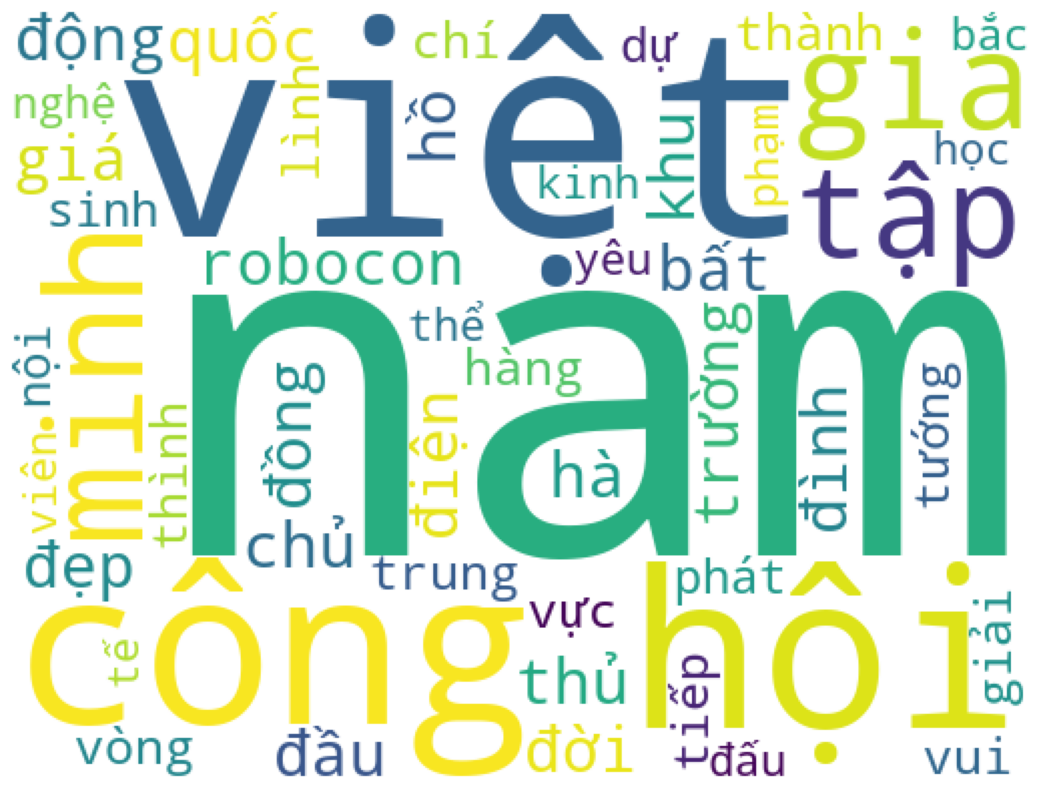

In [37]:
plt.subplots(figsize=(20, 10))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(temp['Common_words']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.savefig('Plotly-World_Cloud.png')
plt.show()

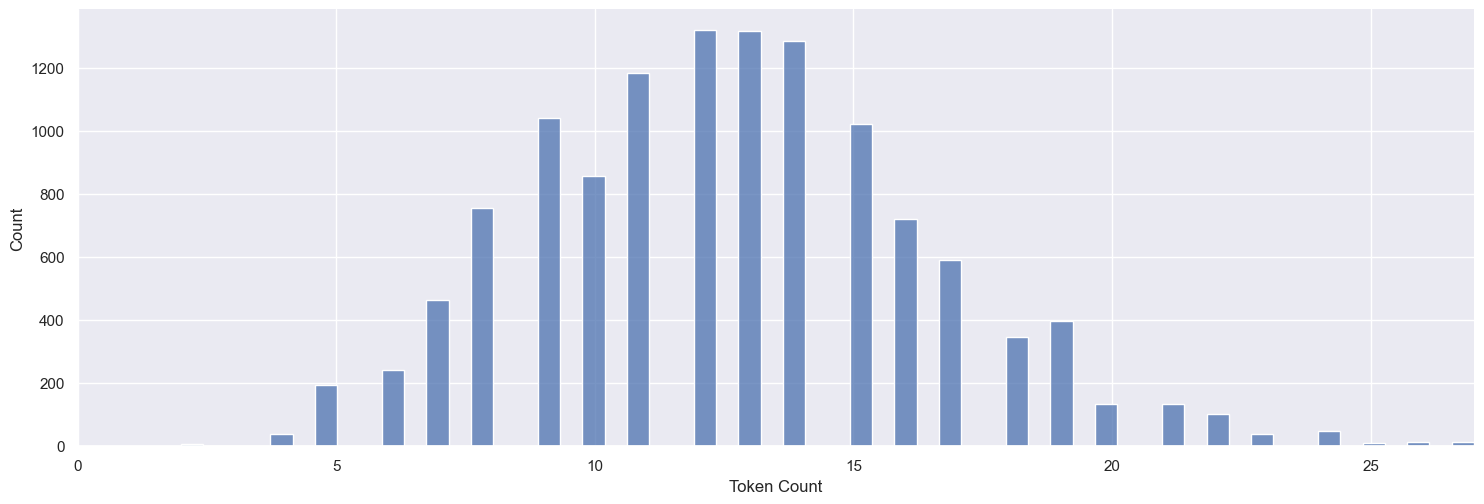

In [38]:
plot_count_token()

In [47]:
df_small.to_excel('./Clean Data/small_data.xlsx', encoding='utf-8')
df_big.to_excel('./Clean Data/big_data.xlsx', encoding='utf-8')

### Conclusion
    - Sau khi dữ liệu thì số lượng nhãn giảm xuống chỉ còn 5 nhãn. 
    - Số lượng các kí hiệu đặc biệt dấu câu giảm đi đáng kể.
    - Số lượng từ dừng giảm đi nhiều giúp cho các câu hầu như điều mang từ có nghĩa.
    - Số lượng từ trong mỗi câu trước khi xử liệu có giá trị max là 40 từ, sau khi xử lý chỉ còn 30 từ.
    - Chuyển từ hoa thành từ thường giúp cho tokenizer hiệu quả hơn.

## Extract feature -> endcode

In [40]:
model

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [41]:
# Define a function to generate sentence embeddings
def generate_sentence_embedding(text):
    # Tokenize the text
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    # Generate the embedding
    with torch.no_grad():
        outputs = model(input_ids)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    return embedding

In [42]:
def encode_lables(df):
    encode_lable.fit(df['Topic'])
    df['Topic'] = encode_lable.transform(df['Topic'])  

In [43]:
def embedding_sentences(df, norm = False, dim = 768):
    df_t = df.copy()
    
    df_t['Content_embedding'] = df_t['Content'].apply(lambda content : generate_sentence_embedding(content))       
    
    if (norm == True):
        norm = Normalizer()
        df_t['Content_embedding'] = df_t['Content_embedding'].apply(lambda x: norm.fit_transform([x])[0])
    if (dim != 768):
        pca = PCA(n_components = dim)
        reduced_embeddings = pca.fit_transform(df_t['Content_embedding'].tolist())

        df_reduced = pd.DataFrame(reduced_embeddings)
        df_t['Content_embedding'] = df_reduced.values.tolist()
    return df_t

In [44]:
def plot_content_3d(df):
    X = np.array(df['Content_embedding'].tolist())
    y = np.array(df['Topic'].tolist())

    # Sử dụng t-SNE để giảm chiều dữ liệu từ không gian đa chiều xuống không gian 3D
    tsne = TSNE(n_components=3)
    embeddings = tsne.fit_transform(X)

    # Tạo biểu đồ 3D và phân biệt các lớp
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Với mỗi lớp, tô màu các điểm tương ứng trên biểu đồ
    for label in np.unique(y):
        indices = np.where(y == label)
        ax.scatter(embeddings[indices, 0], embeddings[indices, 1], embeddings[indices, 2], label=label)

    # Thêm chú thích cho các lớp
    ax.legend()

    # Hiển thị biểu đồ
    plt.show()

In [89]:
def plot_content_2d(df):
    X = np.array(df['Content_embedding'].tolist())
    y = np.array(df['Topic'].tolist())

    # Sử dụng t-SNE để giảm chiều dữ liệu từ không gian đa chiều xuống không gian 2D
    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(X)

    # Tạo biểu đồ 2D và phân biệt các lớp
    plt.figure(figsize=(20, 10))

    # Với mỗi lớp, tô màu các điểm tương ứng trên biểu đồ
    for label in np.unique(y):
        indices = np.where(y == label)
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=label)

    # Thêm chú thích cho các lớp
    plt.legend()

    # Hiển thị biểu đồ
    plt.show()

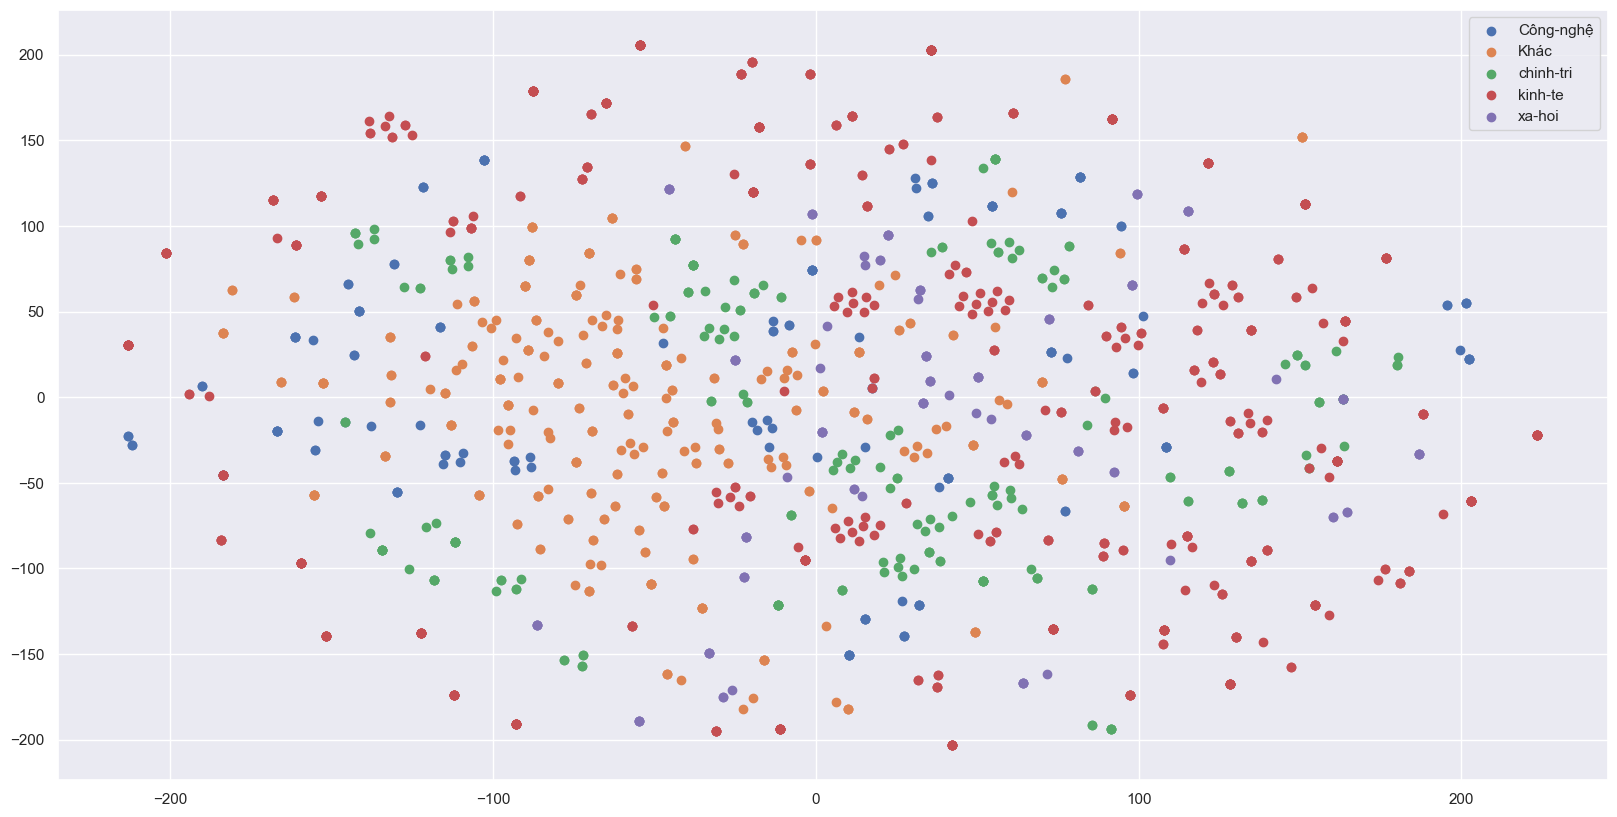

In [90]:
plot_content_2d(embedding_sentences(df_small))

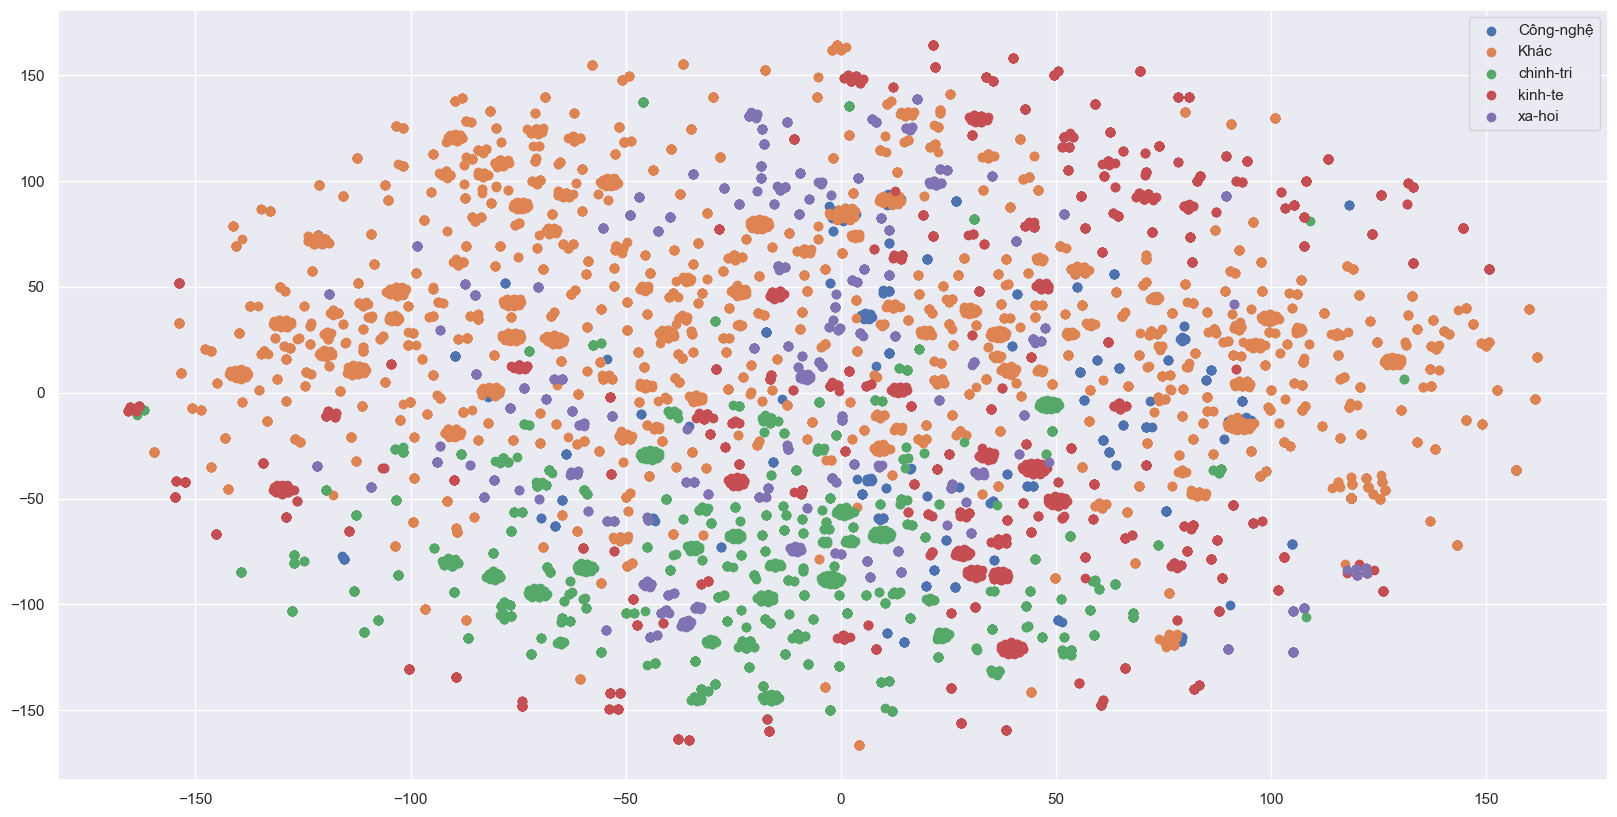

In [91]:
plot_content_2d(embedding_sentences(df_big))

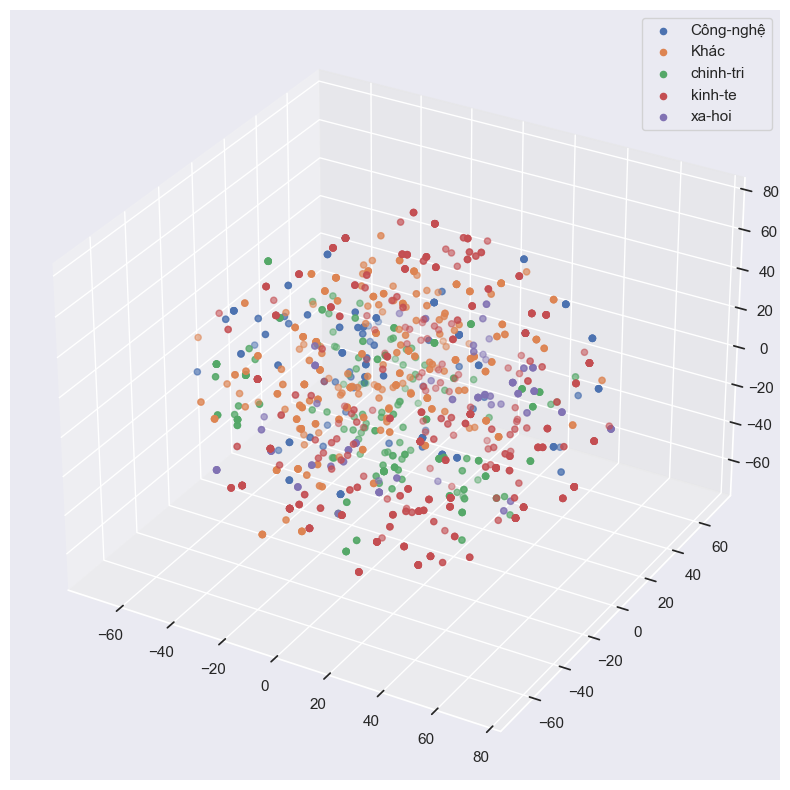

In [92]:
plot_content_3d(embedding_sentences(df_small))

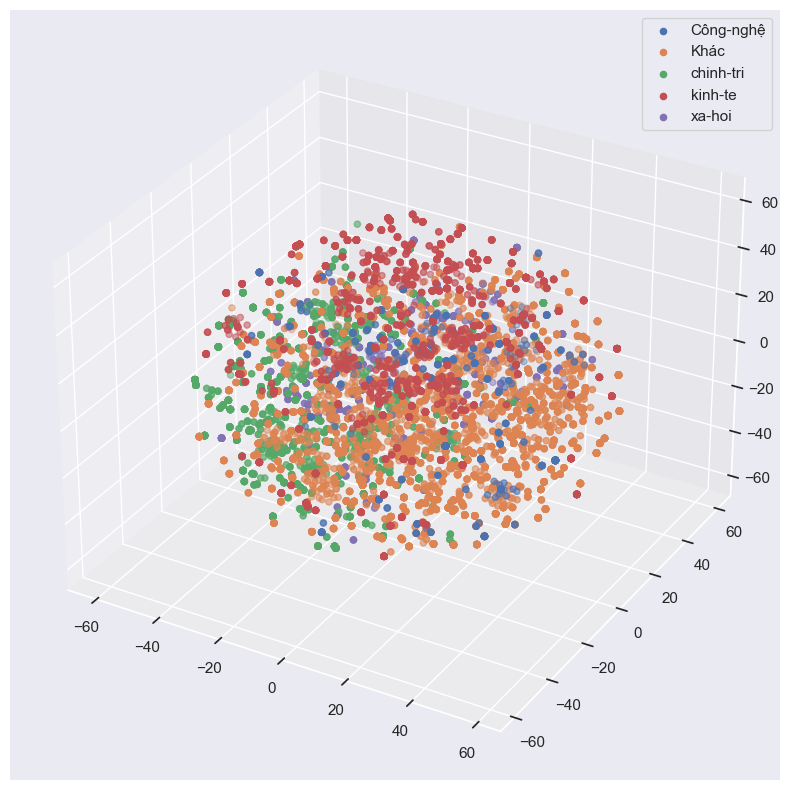

In [93]:
plot_content_3d(embedding_sentences(df_big))

### Nhận Xét:
    - Khi trực quan hóa vector  đặc trưng 768 chiều của mỗi contents về vector 3 chiều ta thấy tập dữ liệu lớn phân cụm rõ ràng hơn tập dữ liệu nhỏ. 
    - 2d cx như vậy tập dữ liệu lớn cho ta thấy sự phân cụm rõ ràng hơn
    - Điều này cho ta thấy các vector có cùng 1 topic sẽ có xu hướng ở gần nhau hơn trong không gian vector.

## Modeling

In [94]:
def get_F1(trained_model,X,y):

    predicted = trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1 = f1_score(y, predicted, average=None)
    # Return the F1 score
    return f1

In [95]:
def eveluation_model(model, X_test, y_test):
    
    #test the model with the test data
    y_pred = model.predict(X_test)
    #calculate the accuracy
    log_reg_accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', log_reg_accuracy,'\n')

    #calculate the F1 score
    f1_Score = get_F1(model,X_test,y_test)
    return pd.DataFrame(f1_Score, index= df_small['Topic'].unique(), columns=['F1 score'])

In [96]:
def training_model_repeat_holdout(model, df, norm = False, dim = 768):
    X = df["Content_embedding"].values
    X = np.vstack(X)
    y = df["Topic"].values
    acc = []
    f1 = []
    recall = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i,stratify=y)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred, average='macro'))
        recall.append(recall_score(y_test, y_pred, average='macro'))
    return np.mean(acc), np.mean(recall), np.mean(f1)

In [97]:
def training_model_cross_val(model, df):
    scoringopt = {  'accuracy' : make_scorer(accuracy_score),
                    'recall': make_scorer(recall_score, average='macro'),
                    'f1_score': make_scorer(f1_score, average='macro')}
    list = []
    X = df["Content_embedding"].values
    X = np.vstack(X)
    y = df["Topic"].values
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoringopt)
    return np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_recall']), np.mean(cv_results['test_f1_score'])

In [98]:
norm = False

model_SVC = SVC(kernel='linear', probability=True)
model_RandomForest = RandomForestClassifier(n_estimators=100, random_state=42)
dims = [128, 256, 512, 768]
data = [df_small]
norm = ['None', 'Norm']
md = [model_SVC, model_RandomForest]
evaluation = [training_model_repeat_holdout, training_model_cross_val]
encode_lables(df_small)
result_list = []
for i in data:
    for j in norm:
        if (j == 'Norm'):
            norm = True 
        else :
            norm = False
        for dim in dims: 
            df_t = embedding_sentences(i, norm = norm, dim= dim)
            for k in md:
                for l in evaluation:
                    acc, recall, f1 = l(k,df_t)
                    result_dict = {
                    'Dataset':  type(i).__name__,
                    'Normalize': j,
                    'Dimension': dim,
                    'Model': type(k).__name__,
                    'evaluation' : l.__name__,
                    'accuracy' : acc,
                    'recall' : recall,
                    'f1' : f1
                    }
                    result_list.append(result_dict)
rs = pd.DataFrame(result_list)
rs

,Dataset,Normalize,Dimension,Model,evaluation,accuracy,recall,f1
0,DataFrame,None,128,SVC,training_model_repeat_holdout,0.932688,0.913221,0.918423
1,DataFrame,None,128,SVC,training_model_cross_val,0.941818,0.921567,0.925894
2,DataFrame,None,128,RandomForestClassifier,training_model_repeat_holdout,0.931477,0.902062,0.918583
3,DataFrame,None,128,RandomForestClassifier,training_model_cross_val,0.944000,0.920720,0.936579
4,DataFrame,None,256,SVC,training_model_repeat_holdout,0.937046,0.917252,0.923379
5,DataFrame,None,256,SVC,training_model_cross_val,0.944727,0.924442,0.927438
6,DataFrame,None,256,RandomForestClassifier,training_model_repeat_holdout,0.922276,0.894554,0.910036
7,DataFrame,None,256,RandomForestClassifier,training_model_cross_val,0.950545,0.927304,0.940755
8,DataFrame,None,512,SVC,training_model_repeat_holdout,0.938257,0.918937,0.925011
9,DataFrame,None,512,SVC,training_model_cross_val,0.944727,0.924442,0.928273


In [99]:
max_accuracy_test = rs.iloc[rs['accuracy'].idxmax()]
print(max_accuracy_test)

Dataset                      DataFrame
Normalize                         Norm
Dimension                          512
Model           RandomForestClassifier
evaluation    training_model_cross_val
accuracy                      0.952727
recall                        0.929075
f1                            0.943232
Name: 27, dtype: object


In [100]:
norm = False

model_SVC = SVC(kernel='linear', probability=True)
model_RandomForest = RandomForestClassifier(n_estimators=100, random_state=42)
dims = [128, 256, 512, 768]
data = [df_big]
norm = ['None', 'Norm']
md = [model_SVC, model_RandomForest]
evaluation = [training_model_repeat_holdout, training_model_cross_val]
encode_lables(df_small)
encode_lables(df_big)
result_list = []
for i in data:
    for j in norm:
        if (j == 'Norm'):
            norm = True 
        else :
            norm = False
        for dim in dims: 
            df_t = embedding_sentences(i, norm = norm, dim= dim)
            for k in md:
                for l in evaluation:
                    acc, recall, f1 = l(k,df_t)
                    result_dict = {
                    'Dataset':  type(i).__name__,
                    'Normalize': j,
                    'Dimension': dim,
                    'Model': type(k).__name__,
                    'evaluation' : l.__name__,
                    'accuracy' : acc,
                    'recall' : recall,
                    'f1' : f1
                    }
                    result_list.append(result_dict)
rs = pd.DataFrame(result_list)
rs

,Dataset,Normalize,Dimension,Model,evaluation,accuracy,recall,f1
0,DataFrame,None,128,SVC,training_model_repeat_holdout,0.967949,0.903145,0.924129
1,DataFrame,None,128,SVC,training_model_cross_val,0.959151,0.902970,0.913164
2,DataFrame,None,128,RandomForestClassifier,training_model_repeat_holdout,0.972924,0.910954,0.934673
3,DataFrame,None,128,RandomForestClassifier,training_model_cross_val,0.965746,0.915272,0.929544
4,DataFrame,None,256,SVC,training_model_repeat_holdout,0.973687,0.912554,0.934230
5,DataFrame,None,256,SVC,training_model_cross_val,0.965013,0.912616,0.924476
6,DataFrame,None,256,RandomForestClassifier,training_model_repeat_holdout,0.972680,0.910724,0.934699
7,DataFrame,None,256,RandomForestClassifier,training_model_cross_val,0.964372,0.914154,0.928696
8,DataFrame,None,512,SVC,training_model_repeat_holdout,0.974023,0.913123,0.934845
9,DataFrame,None,512,SVC,training_model_cross_val,0.967303,0.911088,0.926796


In [101]:
max_accuracy_test = rs.iloc[rs['accuracy'].idxmax()]
print(max_accuracy_test)

Dataset                           DataFrame
Normalize                              None
Dimension                               512
Model                                   SVC
evaluation    training_model_repeat_holdout
accuracy                           0.974023
recall                             0.913123
f1                                 0.934845
Name: 8, dtype: object


### Nhận xét:
    - Chia tập dữ liệu để huấn luyện mô hình bằng 2 phương pháp: repeat hold-out và cross-validate thì các metric đánh giá độ chính xác cho ra kết quả chênh lệch không lớn (1-2%) --> Các metric đánh giá là đáng tin cậy, và việc chia dữ liệu bằng phương pháp nào cx hiệu quả. Nhưng trong các trường hợp cross-validate luôn nhỉnh hơn về độ chính xác so với repeat hold-out.
    - Sau khi trích xuất đặc trưng ta sẽ thực hiện chuẩn hóa các vector đặc trừng: thì các metric đánh giá độ chính xác giảm đi khá nhiều(5- 7%) đối với mô hình sử dụng thuật toán SVM --> Tại vì đề tài sử dụng mô hình trích xuất đằc trưng pre-train đã quá tốt, nên khi chuẩn hóa sẽ làm giảm độ chính xác của các metric đánh giá đo được. 
    - Đối với giảm chiều dữ liệu 
        - 512: 95.20 % (RandomForestClassifier - cross-validate)
        - 256: 94.54 % (RandomForestClassifier - cross-validate)
        - 128: 94.76 % (RandomForestClassifier - cross-validate)
        - so với chiều 768 (không giảm chiều): 95.20 % (RandomForestClassifier - cross-validate)
        ----> Giảm chiều dữ liệu không làm giảm đi độ chính xác của mô hình nên nhóm khuyến khích sử dụng giảm chiều dữ liệu để cho mô hình xử lý nhanh và hiệu quả hơn.
